In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Nelson–Siegel–Svensson (NSS) function
def nelson_siegel_svensson(tau, beta0, beta1, beta2, beta3, lambda1, lambda2):
    # To avoid division by zero, treat tau=0 separately
    term1 = (1 - np.exp(-tau / lambda1)) / (tau / lambda1) if tau != 0 else 1.0
    term2 = term1 - np.exp(-tau / lambda1)
    term3 = (1 - np.exp(-tau / lambda2)) / (tau / lambda2) if tau != 0 else 1.0
    term4 = term3 - np.exp(-tau / lambda2)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term4

# ----------------------------
# Markov-switching parameters (two regimes: 0 = calm, 1 = turbulent)
# ----------------------------
# Transition probability matrix:
#   P[i,j] = Prob(next regime = j | current regime = i)
P = np.array([[0.95, 0.05],
              [0.10, 0.90]])
# Default regime-dependent NSS parameters
# Regime 0: Calm
nss_params_regime0 = {
    'beta0': 0.02,
    'beta1': -0.01,
    'beta2': 0.01,
    'beta3': 0.0,
    'lambda1': 1.0,
    'lambda2': 2.0
}
# Regime 1: Turbulent
nss_params_regime1 = {
    'beta0': 0.03,
    'beta1': -0.02,
    'beta2': 0.015,
    'beta3': 0.005,
    'lambda1': 0.8,
    'lambda2': 1.5
}

In [72]:
# Simulation parameters

T = 2000         # Total number of time steps
dt = 1         # Time increment
theta = 1.0      # Mean reversion speed for the OU process

# Jump parameters
jump_intensity = 0.001
jump_mean = 0.0
jump_std = 0.01

# ----------------------------
# Hull–White parameters for μ (time-dependent mean)
# ----------------------------
kappa_hw = 0.3
theta_hw = 0.0
sigma_hw = 0.005

exp_factor_hw = np.exp(-kappa_hw * dt)
std_factor_hw = np.sqrt((sigma_hw**2 / (2 * kappa_hw)) * (1 - np.exp(-2 * kappa_hw * dt)))

# ----------------------------
# Heston parameters for stochastic volatility (Milstein scheme)
# ----------------------------
v0 = 0.0001          # Initial variance
kappa_v = 1.5        # Variance mean reversion speed
theta_v = 0.0001     # Long-run variance level
sigma_v = 0.005      # Volatility of volatility
rho = -0.5           # Correlation between OU and variance processes

# ----------------------------
# Additional simulation: fixed NSS maturity and regime variable
# ----------------------------
tau_nss = 5.0      # Maturity for yield curve

# Preallocate arrays
spread = np.zeros(T)
mu_t_arr = np.zeros(T)           # Hull–White evolving μ
effective_mu_arr = np.zeros(T)   # Combined mean: Hull–White + NSS yield
variance = np.zeros(T)           # Variance process
volatility = np.zeros(T)         # sqrt(variance)
regime_arr = np.zeros(T, dtype=int)  # Regime indicator (0 or 1)

# Initial conditions
spread[0] = 0.0
mu_t_arr[0] = theta_hw
# For effective μ at time 0, pick regime 0 parameters by default
ns_yield0 = nelson_siegel_svensson(tau_nss, **nss_params_regime0)
effective_mu_arr[0] = theta_hw + ns_yield0
variance[0] = v0
volatility[0] = np.sqrt(v0)
regime_arr[0] = 0  # starting in calm regime

In [73]:
# Simulation loop with Markov switching and NSS-Svensson adjustment
# ----------------------------
for t in range(1, T):
    # --- Markov switching: update regime ---
    current_regime = regime_arr[t-1]
    # Generate a random number to determine next regime
    if np.random.rand() < P[current_regime, 1 - current_regime]:
        regime = 1 - current_regime  # switch regime
    else:
        regime = current_regime      # stay in the same regime
    regime_arr[t] = regime

    # --- Hull–White update for μ ---
    Z_hw = np.random.normal()
    mu_t = theta_hw + (mu_t_arr[t-1] - theta_hw) * exp_factor_hw + std_factor_hw * Z_hw
    mu_t_arr[t] = mu_t

    # --- Nelson–Siegel–Svensson yield based on regime ---
    if regime == 0:
        nss_params = nss_params_regime0
    else:
        nss_params = nss_params_regime1
    ns_yield = nelson_siegel_svensson(tau_nss, **nss_params)
    
    # Combine the short-term Hull–White mean with the NSS yield to form effective μ
    effective_mu = mu_t + ns_yield
    effective_mu_arr[t] = effective_mu

    # --- Generate correlated normals for OU and variance updates ---
    Z1 = np.random.normal()
    Z2 = np.random.normal()
    Z_ou = Z1  # for the OU process
    Z_v = rho * Z1 + np.sqrt(1 - rho**2) * Z2  # for variance update

    # --- Milstein update for the variance process ---
    v_prev = variance[t-1]
    sqrt_v_prev = np.sqrt(max(v_prev, 0))
    # Milstein correction: (sigma_v^2 / 4) * dt * (Z_v^2 - 1)
    dv = kappa_v * (theta_v - v_prev) * dt \
         + sigma_v * sqrt_v_prev * np.sqrt(dt) * Z_v \
         + (sigma_v**2 / 4) * dt * (Z_v**2 - 1)
    v_t = v_prev + dv
    v_t = max(v_t, 0)  # ensure non-negativity
    variance[t] = v_t
    volatility[t] = np.sqrt(v_t)

    # --- Closed-form update for the OU process using effective μ ---
    exp_factor_ou = np.exp(-theta * dt)
    std_factor_ou = np.sqrt((v_prev / (2 * theta)) * (1 - np.exp(-2 * theta * dt)))
    X_t = effective_mu + (spread[t-1] - effective_mu) * exp_factor_ou + std_factor_ou * Z_ou

    # --- Add jump component ---
    if np.random.rand() < jump_intensity:
        jump = np.random.normal(jump_mean, jump_std)
    else:
        jump = 0.0
    spread[t] = X_t + jump

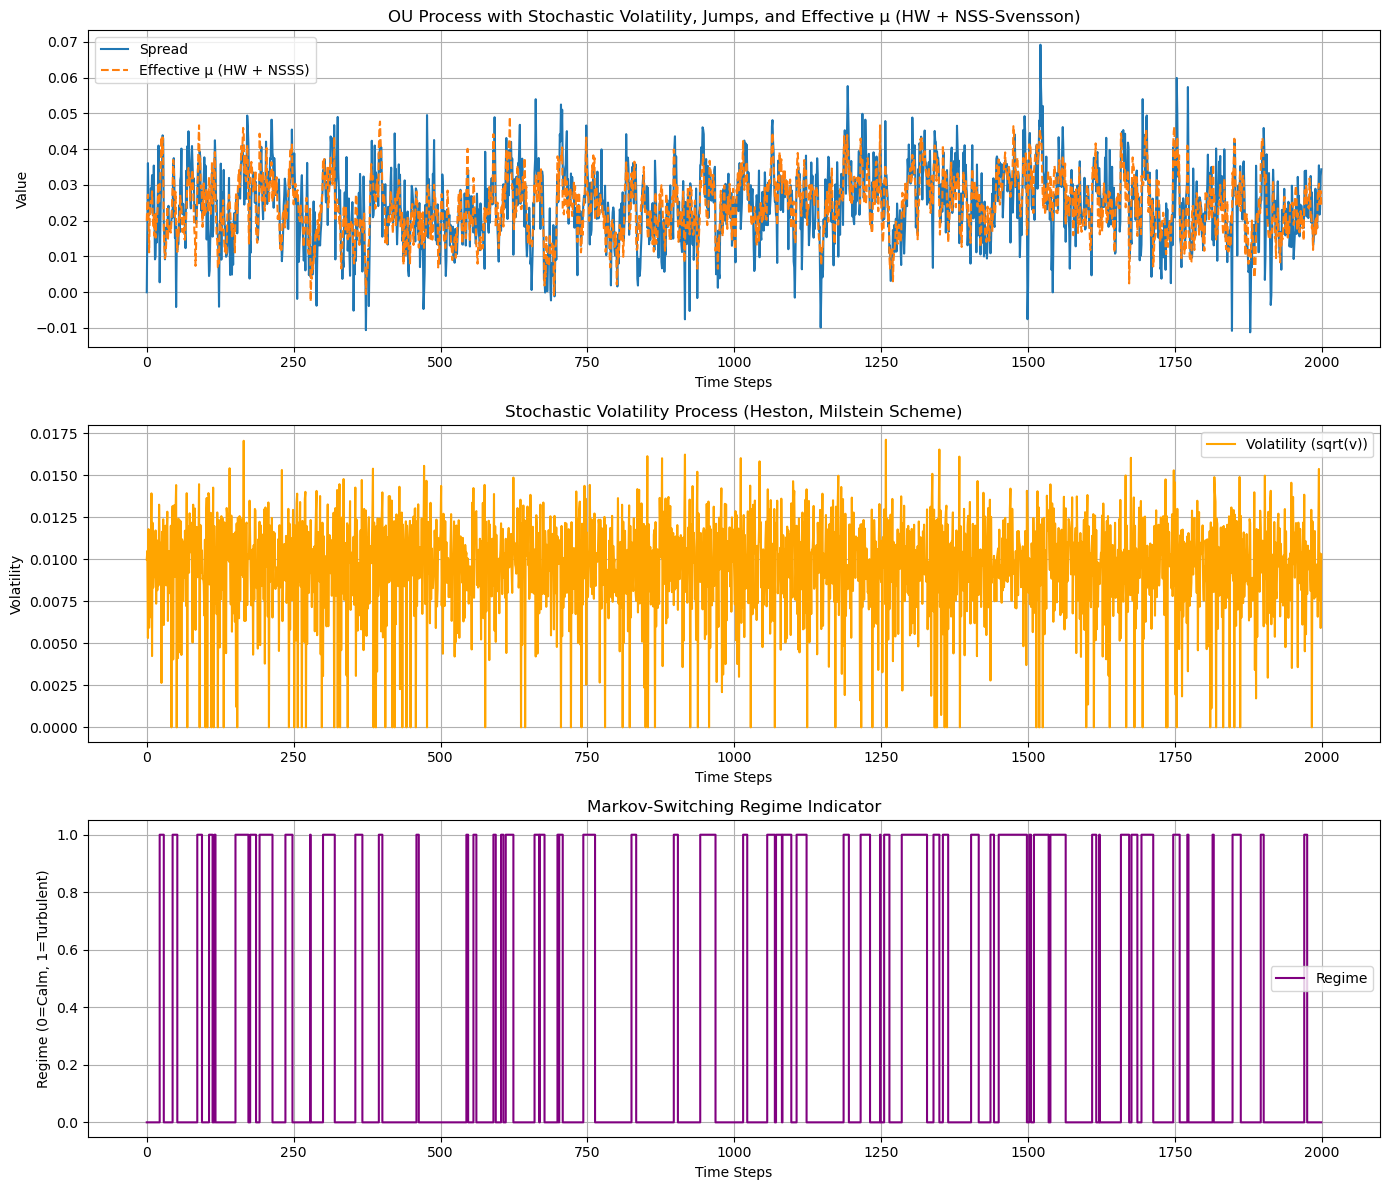

In [74]:
# Plotting results
# ----------------------------
plt.figure(figsize=(14, 12))

# Plot spread and effective mean
plt.subplot(3, 1, 1)
plt.plot(spread, label="Spread")
plt.plot(effective_mu_arr, label="Effective μ (HW + NSSS)", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("OU Process with Stochastic Volatility, Jumps, and Effective μ (HW + NSS-Svensson)")
plt.legend()
plt.grid(True)

# Plot volatility
plt.subplot(3, 1, 2)
plt.plot(volatility, label="Volatility (sqrt(v))", color='orange')
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.title("Stochastic Volatility Process (Heston, Milstein Scheme)")
plt.legend()
plt.grid(True)

# Plot regime changes (as a step function)
plt.subplot(3, 1, 3)
plt.step(range(T), regime_arr, where='post', label="Regime", color='purple')
plt.xlabel("Time Steps")
plt.ylabel("Regime (0=Calm, 1=Turbulent)")
plt.title("Markov-Switching Regime Indicator")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()